<a href="https://colab.research.google.com/github/achanhon/Lispchitz_penalty/blob/master/kolter_method/provable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### from https://locuslab.github.io/2019-03-12-provable/ Kolter


import numpy as np

def generate_data(n=50,scale=2,radius=0.1):
  X = [np.random.uniform(size=(2))*scale]
  i=0
  while(len(X) < n and i<100000):
    x = np.random.uniform(size=(2))*scale
    if min(np.abs(x-z).sum() for z in X) > radius*2:
        X.append(x)

  Y= np.random.randint(0,2,len(X))
  X = np.asarray(X)
  return X,Y

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import torch

def view_data(X,Y,net=None,scale=2,radius=0.1):
  fig, ax = plt.subplots(figsize=(8,8))
  
  if net is not None:
    XX, YY = np.meshgrid(np.linspace(-0.2, scale+0.2, 100), np.linspace(-0.1, scale+0.2, 100))
    X0 = torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T)
    y0 = net(X0)
    ZZ = (y0[:,0] - y0[:,1]).view(100,100).data.numpy()

    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))

  ax.scatter(X[:,0], X[:,1], c=Y, cmap="coolwarm", s=70)
  for x in X:
      ax.add_patch(patches.Rectangle((x[0]-radius/2, x[1]-radius/2), radius, radius, fill=False))

  ax.axis("equal")
  ax.axis([-0.1,scale+0.1,-0.1,scale+0.1])


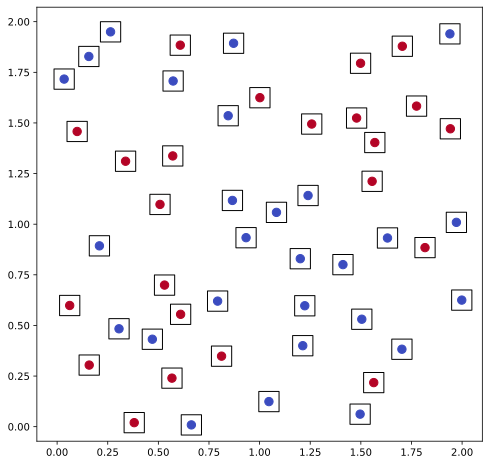

In [2]:
X,Y = generate_data()
view_data(X,Y)


loss 0.6844004 accuracy 0.56
loss 0.41337305 accuracy 0.78
loss 0.34727275 accuracy 0.78
loss 0.31586084 accuracy 0.8
loss 0.29486167 accuracy 0.8
loss 0.27806938 accuracy 0.84
loss 0.2654779 accuracy 0.84
loss 0.25446588 accuracy 0.86
loss 0.24456912 accuracy 0.88
loss 0.23528187 accuracy 0.88
loss 0.22750776 accuracy 0.88
loss 0.22078116 accuracy 0.88
loss 0.2143008 accuracy 0.88
loss 0.20828567 accuracy 0.88
loss 0.20079826 accuracy 0.88
loss 0.1934877 accuracy 0.92
loss 0.18500115 accuracy 0.92
loss 0.1759403 accuracy 0.92
loss 0.16698405 accuracy 0.92
loss 0.15778369 accuracy 0.94


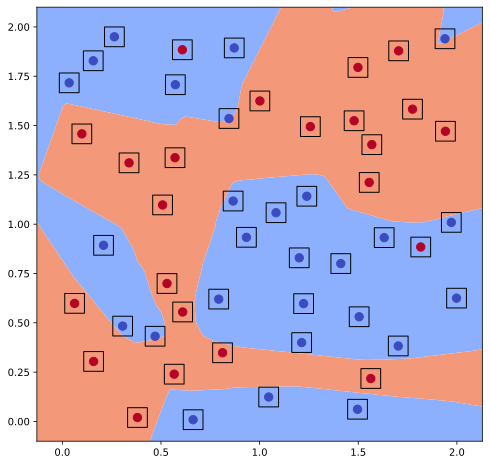

In [3]:
import torch.nn
import torch.optim
import torchvision

net = torch.nn.Sequential(
    torch.nn.Linear(2,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,2)
)
net.train()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

datasetpytorch = torch.utils.data.TensorDataset(torch.Tensor(X), torch.from_numpy(Y).long())
batchengine = torch.utils.data.DataLoader(datasetpytorch, batch_size=32)

for epoch in range(10000):
    accuracy=0
    for x,y in batchengine:
      z = net(x)
      loss = criterion(z,y)
      opt.zero_grad()
      loss.backward()
      opt.step()
      accuracy += (z.max(1)[1] == y).float().sum()

    if epoch % 500 == 0:
      print("loss",loss.cpu().detach().numpy(),"accuracy",accuracy.cpu().detach().numpy()/X.shape[0])

view_data(X,Y,net)

Training a provably robust network


In [4]:
epsilon = 0.1

finetuning = True
if not finetuning:
  net = torch.nn.Sequential(
    torch.nn.Linear(2,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,2)
  )
  net.train()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

datasetpytorch = torch.utils.data.TensorDataset(torch.Tensor(X), torch.from_numpy(Y).long())
batchengine = torch.utils.data.DataLoader(datasetpytorch, batch_size=32)

W1, b1 = net[0].weight, net[0].bias
W2, b2 = net[2].weight, net[2].bias

In [5]:
def bounds_pt(inputs, net): 
    X2 = torch.nn.functional.linear(inputs, W1, bias=b1)
    l,u = X2 - epsilon*W1.abs().sum(1), X2 + epsilon*W1.abs().sum(1)
    return torch.clamp(l,max=0), torch.clamp(u,min=0)

In [6]:
class DualNet(torch.nn.Module): 
    def forward(self, c, l, u): 
        nu3 = -c
        nu2hat = torch.nn.functional.linear(nu3, W2.t())
        nu2 = u/(u-l)*nu2hat
        nu1 = torch.nn.functional.linear(nu2, W1.t())
        return (nu1,nu2,nu3)

dualnet = DualNet()

In [7]:
def bdot(inputs,targets): 
    return torch.matmul(inputs.unsqueeze(-2),targets.unsqueeze(-1)).squeeze(-1).squeeze(-1)

def J(nu1, nu2, nu3, l,I, inputs): 
    return (- bdot(nu1, inputs) - epsilon*nu1.abs().sum(-1)- bdot(nu2, b1) 
            + (l*torch.clamp(nu2,min=0)*I.float()).sum(-1) - bdot(nu3,b2))

loss 1.734106 accuracy 0.96
loss 0.87364936 accuracy 0.92
loss 0.79151654 accuracy 0.92
loss 0.73219234 accuracy 0.92
loss 0.69389427 accuracy 0.94
loss 0.66418296 accuracy 0.94
loss 0.6493351 accuracy 0.94
loss 0.62981004 accuracy 0.9
loss 0.61234283 accuracy 0.9
loss 0.5956207 accuracy 0.88


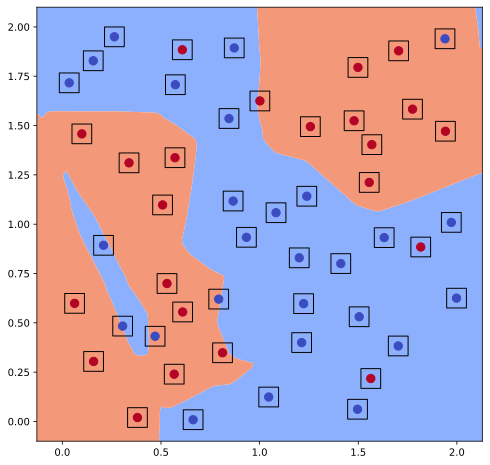

In [8]:
for epoch in range(5000):
    accuracy=0
    for x,y in batchengine:

    # Compute upper and lower bounds
        l,u = bounds_pt(x, net)
        I = (u > 0)*(l < 0)
        
        # Pass through dual network
        c = torch.eye(2)[y]*2-1
        nu1,nu2,nu3 = dualnet(c,l,u)
        
        # Compute objective and loss
        dual_obj = J(nu1,nu2,nu3,l,I,x)
        loss = criterion(-dual_obj.unsqueeze(-1)*(torch.eye(2)[~y]), y)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # Compute error and robust error
        z = net(x)
        accuracy += (z.max(1)[1] == y).float().sum()

    if epoch % 500 == 0:
      print("loss",loss.cpu().detach().numpy(),"accuracy",accuracy.cpu().detach().numpy()/X.shape[0])

view_data(X,Y,net)